# **Introduction**



NLP(Natural Language Processing) là khái niệm để chỉ các kĩ thuật, phương pháp thao tác trên ngôn ngữ tự nhiên bằng máy tính. Bạn cần phân biệt ngôn ngữ tự nhiên (ví dụ như tiếng Việt, tiếng Anh, tiếng Nhật… là những ngôn ngữ trong giao tiếp thường ngày) và ngôn ngữ nhân tạo ( như ngôn ngữ lập trình, ngôn ngữ máy, …).

Trong NLP có 2 quan điểm cơ bản :

1. Xử lý các từ ngữ bằng máy tính.

2. Làm cho máy tính hiểu được các từ ngữ.

Hiện tại, cả 2 hướng này đều đang được tích cực nghiên cứu và phát triển, nhờ đó rất nhiều các hệ thống hiệu quả đã và đang được tạo ra.

Các ứng dụng cơ bản của NLP :

1. Chế tạo các hệ thống Máy dịch, ví dụ như Google translation.

2. Xử lý văn bản và ngôn ngữ.

3. Tìm kiếm thông tin.

4. Chiết suất thông tin.

5. Tóm tắt văn bản.

6. Phân loại văn bản.

7. Data mining, web mining. 

Các loại dữ liệu NLP xử lý:
1. Text(hẳng hạn như trong email, bài đăng blog, sách, Tweet)
2. Speech(Cuộc trò chuyện, lệnh đưa ra đối với các thiết bị thông minh)

Cả hai loại dữ liệu này thường được gọi là chuỗi (một câu là một chuỗi các từ). Vì vậy, một thuật ngữ phổ biến = sẽ gặp trong các bài toán NLP được gọi là seq2seq, nói cách khác, tìm kiếm thông tin trong một chuỗi để tạo ra một chuỗi khác (ví dụ: chuyển đổi một lệnh thoại thành một chuỗi văn bản).

Để thực hành NLP trong TensorFlow, chúng ta sẽ thực hành các bước chúng ta đã sử dụng trước đây nhưng lần này với dữ liệu văn bản:

`Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)`

In [ ]:
# Get helper_functions.py script from course Github
!wget https://raw.githubusercontent.com/Wassefy/tensorflow/main/Extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys


--2021-06-28 16:06:16--  https://raw.githubusercontent.com/Wassefy/tensorflow/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2021-06-28 16:06:16 (92.7 MB/s) - ‘helper_functions.py’ saved [10234/10234]



# **Tải và trực quan hóa dữ liệu**

Trong phần này chúng ta sẽ tải và sử dụng bộ dữ liệu [Real or Not](https://www.kaggle.com/c/nlp-getting-started/data?select=sample_submission.csv) Dự báo những Tweet nào nói về thảm họa tự nhiên thực sự và những Tweet nào không.

Ví dụ:
- Tweet nói về thảm họa tự nhiên: `Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano`
- Tweet không nói về thảm họa tự nhiên: `'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote`

`


In [ ]:

# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-06-28 16:06:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2021-06-28 16:06:18 (147 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Sau khi tải xong dữ liệu chúng ta đi xem xét nó

In [ ]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


Nhìn vào bảng dữ liệu ta cần chú ý vào cột '`target`'. Chúng ta sẽ tiến hành viết code để tìm các mẫu thuộc cột '`text`' của tập dữ liệu đào tạo để dự đoán giá trị của cột '`target`'. Tập dữ liệu thử nghiệm sẽ không có cột '`target`'.

In [ ]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


`Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)`

In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Vì chúng ta chỉ có hai trạng thái là Tweet đúng và sai nên ở đây sẽ sử dụng phân loại nhị phân để giải quyết vấn đề.Bộ dữ liệu khá cân bằng khoảng 60% kết quả tiêu cực (target = 0) và 40% kết quả tích cực (target = 1).

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


Trực quan hóa dữ liệu 

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Uber reduces drunk driving fatalities says independent study http://t.co/jVIVT6zrv7

---

Target: 0 (not real disaster)
Text:
Black Ops 3 SEARCH AND DESTROY GAMEPLAY! (Hunted SnD Competitive Multiplayer): http://t.co/ss1zL36y9V via @YouTube

---

Target: 1 (real disaster)
Text:
The Latest: More homes razed by Northern California wildfire - http://t.co/P3g3bQBczu http://t.co/RpBxdfnx5k

---

Target: 0 (not real disaster)
Text:
I attacked Robot-lvl 19 and I've earned a total of 6615434 free satoshis! http://t.co/DMLJ1aGoTw #robotcoingame #Bitcoin #FreeBitcoin

---

Target: 1 (real disaster)
Text:
The Cafe Run by Acid Attack Survivors in #India http://t.co/qmiF0bLwOa http://t.co/l6PIf3LpEn

---



# **Chia dữ liệu thành các tập hợp đào tạo và xác nhận**

Vì tập hợp thử nghiệm không có nhãn và chúng ta cần một cách để đánh giá các mô hình được đào tạo của mình, chúng tôi sẽ tách một số dữ liệu đào tạo và tạo một tập hợp xác thực.Khi mô hình của chúng ta đào tạo (thử các mẫu trong các mẫu Tweet), nó sẽ chỉ thấy dữ liệu từ nhóm đào tạo và chúng ta có thể thấy cách nó hoạt động trên dữ liệu không nhìn thấy bằng cách sử dụng bộ xác thực.

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

# **Chuyển đổi văn bản thành số**

Chúng ta đã có một bộ đào tạo và một bộ xác thực sau khi chia từ dữ liệu đào tạo gốc. Vấn đề hiện tại là nhãn của chúng ta là dạng số(0 và 1) nhưng các Tweet lại là dạng văn bản(chuỗi). Vậy nên để có thể áp dụng các thuật toán học máy thì điều đầu tiên chúng ta cần là chuyển dữ liệu sang dạng số.

Trong NLP có hai các chính để chuyển dữ liệu từ dạng văn bản sang dạng số:
- **Tokenization** - Ánh xạ thẳng từ từ hoặc ký tự hoặc từ phụ(sub-word) sang giá trị số.Cự thể:
> 1. **word-level tokenization**: Sử dụng Tokenization cấp độ từ với câu "I love TensorFlow" có thể dẫn đến "I" là 0, "love" là 1 và "TensorFlow" là 2. Trong trường hợp này, mỗi từ trong một chuỗi được coi là một token duy nhất.
> 2.**Character-level tokenization:** chuyển đổi các chữ cái A-Z thành các giá trị 1-26. Trong trường hợp này, mọi ký tự trong một chuỗi được coi là một token duy nhất.
> 3. **Sub-word tokenization**: nằm giữa word-level tokenization và Character-level tokenization.Chia các từ thành các phần nhỏ sau đó ánh xạ các phần đó thành số.
- **Embeddings** - Phép nhúng là một biểu diễn của ngôn ngữ tự nhiên có thể học được.Biểu diễn có dạng vector đặc trưng. Ví dụ từ "dance" có thể biểu diễn bằng vector 5 chiều `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112] `.Điều quan trọng cần lưu ý ở đây, kích thước của vector đặc trưng có thể điều chỉnh được. Có hai cách để sử dụng nhúng:
> 1. Tạo mới: Khi văn bản đã được chuyển thành số (bắt buộc đối với một lần nhúng),có thể đưa chúng qua một lớp nhúng (chẳng hạn như `tf.keras.layers.Embedding`) và cách biểu diễn nhúng sẽ được học trong quá trình đào tạo mô hình.
> 2. Sử dụng lại nhúng đã được đào tạo trước: Nhiều phương pháp nhúng đã được đào tạo trước tồn tại trực tuyến. Những cách nhúng được đào tạo trước này thường được học trên các kho văn bản lớn (chẳng hạn như Wikipedia) và do đó có một cách thể hiện tốt cơ bản của ngôn ngữ tự nhiên.Chúng ta có thể sử dụng phương pháp nhúng được đào tạo trước để khởi tạo mô hình của mình và tinh chỉnh nó cho phù hợp với nhiệm vụ cụ thể.

## **Vector hóa văn bản(tokenization)**

Để thực hiện mã hóa các từ, chúng ta sẽ sử dụng lớp tiền xử lý `tf.keras.layers.experimental.preprocessing.TextVectorization`.Lớp `TextVectorization` nhận các tham số sau:
- `max-tokens` - Số từ tối đa trong vốn từ vựng của chúng ta, bao gồm 1 giá trị co OOV token(ngoài từ vựng).
- `standardize` - phương pháp chuẩn hóa văn bản.Mặc định là "`Lower_and_strip_punctuation`" làm giảm văn bản và xóa tất cả các dấu câu.
- `split` - cách chia văn bản, mặc định là '`whitespace`' chia trên các khoảng trắng.
- `ngrams`- có bao nhiêu từ cần chứa cho mỗi lần phân chia token, ví dụ `ngrams = 2` chia token thành chuỗi liên tục của 2.
- `output_mode` - cách xuất token, có thể là `"int"` (ánh xạ số nguyên), `"binary"`(mã hóa one-hot), `"count"` hoặc `"tf-idf"`.
- `output_sequence_lenght` - độ dài của chuỗi mã hóa xuất ra. 
- `pad_to_max_tokens` - Nếu True (mặc định), trục tính năng đầu ra sẽ được đệm thành `max_tokens` ngay cả khi số lượng thẻ duy nhất trong từ vựng ít hơn `max_tokens`.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization
text_vectorizer = TextVectorization(max_tokens=None, 
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int", 
                                    output_sequence_length=None, 
                                    pad_to_max_tokens=True)

Trên đây là một khởi tạo TextVectorization với cài đặt mặc định. Tiếp theo chúng ta sẽ đi tủy chỉnh một số thông số để phù hợp với mục đính của mình.
Đặc biệt,là đặt giá trị `max_tokens` và `output_sequence_length`.
Đối với `max_tokens` (số lượng từ trong từ vựng),thường đặt là  bội số của 10.000 (10.000, 20.000, 30.000) hoặc số từ duy nhất chính xác trong văn bản sẽ làm việc (ví dụ: 62.179) là các giá trị phổ biến.Trong trường hợp này chúng ta sẽ sử dụng 10.000. Và đối với `output_sequence_length`, chúng ta sẽ sử dụng số lượng mã thông báo trung bình trên mỗi Tweet trong tập huấn luyện.

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

Để vector hóa tùy chỉnh `text_vectorizer` vào dữ liệu , chúng ta có thể gợi phương thức `adapt()` trên đó trong khi truyền vào văn bản đào tạo của mình.

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
@RosemaryTravale Do we all use the same weapon? 'cause we might be screwed XD      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[8978,   68,   46,   44,  447,    2,  726,  263,  257,   46,  843,
          21, 8730, 1916,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## **Tạo một nhúng bằng lớp nhúng**

Điều mạnh mẽ về cách nhúng là nó có thể học được trong quá trình đào tạo. Điều này có nghĩa là thay vì chỉ là tĩnh (ví dụ: 1 = I, 2 = love, 3 = TensorFlow), biểu diễn số của một từ có thể được cải thiện khi một mô hình đi qua các mẫu dữ liệu.Chúng ta có thể thấy việc nhúng một từ như thế nào bằng cách sử dụng lớp `tf.keras.layers.Embedding.`Các thông số chính mà chúng ta quan tâm ở đây là:
- `input_dim` - Kích thước của từ vựng.
- `output_dim` - Kích thước của vectơ nhúng đầu ra, ví dụ: giá trị 100 sẽ xuất ra vectơ đặc trưng có kích thước 100 cho mỗi từ.
- `embeddings_initializer` - Cách khởi tạo ma trận nhúng,mặc định là `"uniform"` ngẫu nhiên tạo ra ma trận nhúng có phân phối đều.Điều này có thể được thay đổi để sử dụng các phương pháp nhúng đã học trước.
- `input_lenght` - Độ dài của dãy được chuyển đến lớp nhúng.

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding

Hãy chú ý cách nhúng một lớp TensoFlow? Điều này rất quan trọng vì chúng ta có thể sử dụng nó như một phần của mô hình, có nghĩa là các tham số của nó (biểu diễn từ) có thể được cập nhật và cải thiện khi mô hình học.

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02958581, -0.01827241,  0.01755928, ...,  0.03137148,
          0.03219812,  0.02740312],
        [-0.04216301,  0.02720702,  0.02656131, ...,  0.00049473,
         -0.04333213,  0.03193778],
        [-0.0485543 ,  0.024884  , -0.01338657, ...,  0.01699643,
          0.04919944,  0.00560246],
        ...,
        [-0.03342596,  0.02535467,  0.00383983, ...,  0.00984838,
         -0.01201522,  0.00933059],
        [-0.01554222, -0.04623461,  0.03652329, ..., -0.01084423,
         -0.02374125,  0.00553109],
        [ 0.02848505, -0.02369044,  0.0454335 , ...,  0.03211285,
         -0.00294398, -0.01950049]]], dtype=float32)>

Mỗi token trong câu được chuyển thành một vector đặc trưng có độ dài 128.

In [ ]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02958581, -0.01827241,  0.01755928, -0.00767253,  0.02846822,
       -0.01893332, -0.01097124, -0.00320617,  0.03258329, -0.01736655,
        0.03068644, -0.01613341,  0.02483337,  0.00366951,  0.04991141,
       -0.02770906, -0.01477566, -0.03978081, -0.03152939, -0.02229257,
       -0.04454011, -0.00661216, -0.01975546, -0.04510192,  0.00393914,
       -0.01248174,  0.04146205, -0.04510004, -0.04840701, -0.00287011,
        0.02761406,  0.02577703,  0.00620513, -0.022595  ,  0.02893002,
        0.0197631 , -0.02201543,  0.020131  ,  0.03101948,  0.03299582,
       -0.0085776 ,  0.01849792, -0.03515804,  0.0031064 , -0.0378454 ,
       -0.01557378, -0.04670259, -0.02205813,  0.04629186,  0.02400775,
        0.03637478,  0.00463959,  0.03611099, -0.01972885, -0.04447008,
        0.04368213, -0.0174072 ,  0.03004416, -0.00974355,  0.00991337,
        0.04702238, -0.02868366, -0.03368513, -0.03712898,  0.04077243,
       -0.044213

Những giá trị này có thể không có nhiều ý nghĩa đối với chúng ta nhưng chúng là những gì máy tính của chúng tôi nhìn thấy mỗi từ. Khi mô hình của chúng ta tìm kiếm các mẫu trong các mẫu khác nhau, các giá trị này sẽ được cập nhật khi cần thiết.

# **Mô hình hóa tập dữ liệu văn bản**

Chúng ta đã có dữ liệu dưới dạng số bằng cách sử dụng ánh xạ, bây giờ có thể tiến hành xây dựng các mô hình để mô hình hóa tập dữ liệu.Để có được kết quả tốt nhất, chúng ta sẽ xây dựng một loạt các mô hình khác nhau, mỗi mô hình là một thử nghiệm của riêng nó. Sau đó, chúng ta sẽ so sánh kết quả của từng mô hình và xem mô hình nào hoạt động tốt nhất.
Cụ thể hơn, chúng ta sẽ xây dựng những thứ sau:
1. Model 0: Naive Bayes (cơ sở)
2. Model 1: Feed-forward neural network(Dense model)
3. Model 2: LSTM
4. Model 3: GRU 
5. Model 4: LSTM 2 chiều
6. Model 5: 1D CNN
7. Model 6: Trích xuất tính năng với TensorFlow Hub
8. Model 7: Giống với Model 6 với 10% dữ liệu.



## **Model 0: Mô hình cơ sở**

Như với tất cả các thử nghiệm mô hình học máy, điều quan trọng là tạo mô hình cơ sở để bạn có điểm chuẩn cho các thử nghiệm trong tương lai để xây dựng.
Để tạo đường cơ sở, chúng ta sẽ tạo một Đường ống Scikit-Learn bằng cách sử dụng công thức TF-IDF  để chuyển đổi các từ của chúng ta thành số và sau đó lập mô hình bằng thuật toán Naive Bayes. Điều này đã được chọn thông qua việc tham khảo bản đồ học máy Scikit-Learn.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Lợi ích của việc sử dụng một mô hình nông như Multinomial Naive Bayes là việc huấn luyện diễn ra rất nhanh.

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## Tạo chức năng đánh giá cho các thử nghiệm mô hình của chúng ta

Để có thể dễ dàng đánh giá kết quả của mô hình, chúng ta sẽ xây dựng hàm trợ giúp lấy một loạt các dự đoán và nhãn sự thật cơ bản và tính toán những điều sau.
- Accuracy - độ chính xác.
- Precision - tính rõ ràng.
- Recall - gọi lại
- F1-score - Điểm F1

Vì chúng ta đang giải quyết vấn đề phân loại, các số liệu trên là thích hợp nhất. Nếu chúng ta đang làm việc với một vấn đề hồi quy, các số liệu khác như MAE (sai số tuyệt đối có nghĩa là) sẽ là lựa chọn tốt hơn.

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## **Model 1: Mô hình Dense đơn giản**

Mô hình học sâu đầu tiên mà chúng ta sẽ xây dựng là một mô hình lớp Dense.Nó sẽ lấy văn bản và nhãn của chúng ta làm đầu vào, mã hóa văn bản, tạo nhúng, tìm mức trung bình của việc nhúng (sử dụng GlobalAveragePooling) và sau đó chuyển mức trung bình qua một lớp được kết nối đầy đủ với một đơn vị đầu ra và chức năng kích hoạt sigmoid .

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
# inputs are 1-dimensional strings
inputs = layers.Input(shape=(1,), dtype="string") 

# turn the input text into numbers
x = text_vectorizer(inputs) 

# create an embedding of the numerized numbers
x = embedding(x) 

# lower the dimensionality of the embedding (try running the model without this layer and see what happens)
x = layers.GlobalAveragePooling1D()(x)

# create the output layer, want binary outputs so use sigmoid activation
outputs = layers.Dense(1, activation="sigmoid")(x) 
# construct the model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

Mô hình của chúng ta lấy một chuỗi 1 chiều làm đầu vào ( Tweet), sau đó nó mã hóa chuỗi bằng cách sử dụng `text_vectorizer` và tạo một nhúng bằng cách sử dụng `embedding`.Sau đó, chúng ta (tùy chọn) gộp các đầu ra của lớp nhúng để giảm kích thước của tensor mà chúng ta truyền cho lớp đầu ra.Cuối cùng, chúng ta chuyển đầu ra của lớp gộp thành một lớp dày đặc với kích hoạt `sigmoid` ( sử dụng `sigmoid` vì vấn đề là phân loại nhị phân).

Trước khi chúng ta có thể điều chỉnh mô hình của mình cho phù hợp với dữ liệu, chúng ta phải biên dịch nó. Vì chúng ta đang làm việc với phân loại nhị phân, chúng ta sẽ sử dụng "binary_crossentropy" làm hàm mất mát của chúng ta và trình tối ưu hóa `Adam`.

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Hầu hết các tham số có thể đào tạo được chứa trong lớp nhúng. Nhớ lại, chúng ta đã tạo một nhúng có kích thước 128 (`output_dim = 128`) cho từ vựng có kích thước 10.000 (`input_dim = 10000`), do đó có 1.280.000 tham số có thể đào tạo.

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210628-160626
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6112 - accuracy: 0.6935 - val_loss: 0.5344 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4409 - accuracy: 0.8173 - val_loss: 0.4688 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3468 - accuracy: 0.8605 - val_loss: 0.4586 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2840 - accuracy: 0.8910 - val_loss: 0.4623 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2372 - accuracy: 0.9120 - val_loss: 0.4889 - val_accuracy: 0.7940


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4889 - accuracy: 0.7940


[0.4889355003833771, 0.7939632534980774]

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data" \
     --description "Trying a dense model with an embedding layer" \
  --one_shot # exits the uploader when upload has finished

2021-06-28 16:06:47.892829: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.25246558],
       [0.801432  ],
       [0.99802905],
       [0.09998302],
       [0.10098734],
       [0.9284608 ],
       [0.90893734],
       [0.99403137],
       [0.9629521 ],
       [0.24785067]], dtype=float32)

Vì lớp cuối cùng của chúng ta sử dụng chức năng kích hoạt `sigmoid`, chúng ta lấy lại các dự đoán của mình dưới dạng xác suất.Để chuyển đổi chúng thành các lớp dự đoán, chúng tôi sẽ sử dụng tf.round (), nghĩa là xác suất dự đoán dưới 0,5 sẽ được làm tròn thành 0 và những xác suất trên 0,5 sẽ được làm tròn thành 1.



In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.39632545931758,
 'f1': 0.7899134672804106,
 'precision': 0.8031272377768599,
 'recall': 0.7939632545931758}

In [ ]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True, False,  True,  True])

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 79.40, Difference: 0.13
Baseline precision: 0.81, New precision: 0.80, Difference: -0.01
Baseline recall: 0.79, New recall: 0.79, Difference: 0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00


## Trực quan hóa quá trình học nhúng

Mô hình đầu tiên của chúng ta (model_1) chứa một lớp nhúng (embedding) đã học được cách biểu diễn các từ dưới dạng vectơ đặc trưng bằng cách chuyển qua dữ liệu đào tạo.để dễ hình dung chúng ta sẽ đi trực quan hóa quá trình học nhúng đó. Để làm vậy, chúng ta sẽ sử dụng công cụ `Embedding Projector` với hai thông số là số lượng từ vựng và kích thước đầu ra của lớp nhúng.

In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
# same size as vocab size and embedding_dim (each word is a embedding_dim size vector)
print(embed_weights.shape) 

(10000, 128)


In [ ]:
 # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
 import io

 # Create output writers
 out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
 out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

 # Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
   if num == 0: 
      continue # skip padding token
   vec = embed_weights[num]
   out_m.write(word + "\n") # write words to file
   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

 # Download files locally to upload to Embedding Projector
try:
   from google.colab import files
except ImportError:
   pass
else:
   files.download("embedding_vectors.tsv")
   files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Recurrent Neural Networks (RNN's)**


Đối với loạt thử nghiệm mô hình hóa tiếp theo, chúng ta sẽ sử dụng một loại mạng nơ-ron đặc biệt được gọi là Mạng nơ-ron tuần hoàn (RNN).

Tiền đề của một RNN rất đơn giản: sử dụng thông tin từ quá khứ để giúp bạn trong tương lai (đây là nguồn gốc của thuật ngữ lặp lại). Nói cách khác, lấy một đầu vào (`X`) và tính toán một đầu ra (`y`) dựa trên tất cả các đầu vào trước đó.Khái niệm này đặc biệt hữu ích khi xử lý các chuỗi như các đoạn văn bản ngôn ngữ tự nhiên (chẳng hạn như Tweet).

Khi một RNN xem xét một chuỗi văn bản (đã ở dạng số), các mẫu nó học được liên tục cập nhật dựa trên thứ tự của chuỗi.Đối với một ví dụ đơn giản, hãy lấy hai câu:
1. Massive earthquake last week, no?
2. No massive earthquake last week.

Cả hai đều chứa những từ giống hệt nhau nhưng có nghĩa khác nhau. Thứ tự của các từ quyết định ý nghĩa (người ta có thể tranh luận các dấu câu cũng quyết định ý nghĩa nhưng vì đơn giản, chúng ta hãy tập trung vào các từ).

Mạng nơron lặp lại có thể được sử dụng cho một số vấn đề dựa trên trình tự:
- **One to One** - một đầu vào, một đầu ra, chẳng hạn như phân loại hình ảnh.
- **One to many** - một đầu vào, nhiều đầu ra, chẳng hạn như chú thích hình ảnh (đầu vào hình ảnh, một chuỗi văn bản làm đầu ra phụ đề).
- **Many to one** - nhiều đầu vào, một đầu ra, chẳng hạn như phân loại văn bản (phân loại một Tweet là thảm họa thực sự hoặc không phải thảm họa thực sự).
- **Many to many** - nhiều đầu vào, nhiều đầu ra, chẳng hạn như dịch máy (dịch tiếng Anh sang tiếng Việt) hoặc lời nói thành văn bản (sóng âm thanh làm đầu vào, văn bản dưới dạng đầu ra).

Trong thực tế, chúng ta thường gặp các biến thể của RNN's:
- Các ô nhớ ngắn hạn dài hạn (LSTMs)
- Đơn vị định kỳ được xác định (GRUs)
- RNN's hai chiều ( duyệt chuỗi theo 2 chiều, từ trái sang phải và từ phải sang trái)



## **Model 2: LSTM**

Mạng bộ nhớ dài-ngắn (Long Short Term Memory networks), thường được gọi là LSTM - là một dạng đặc biệt của RNN, nó có khả năng học được các phụ thuộc xa. LSTM được giới thiệu bởi Hochreiter & Schmidhuber (1997), và sau đó đã được cải tiến và phổ biến bởi rất nhiều người trong ngành. Chúng hoạt động cực kì hiệu quả trên nhiều bài toán khác nhau nên dần đã trở nên phổ biến như hiện nay.

LSTM được thiết kế để tránh được vấn đề phụ thuộc xa (long-term dependency). Việc nhớ thông tin trong suốt thời gian dài là đặc tính mặc định của chúng, chứ ta không cần phải huấn luyện nó để có thể nhớ được. Tức là ngay nội tại của nó đã có thể ghi nhớ được mà không cần bất kì can thiệp nào.

Để khai thác sức mạnh của ô LSTM (ô LSTM và lớp LSTM thường được sử dụng thay thế cho nhau) trong TensorFlow, chúng ta sẽ sử dụng tensorflow.keras.layers.LSTM ().

Mô hình của chúng ta sẽ có cấu trúc rất giống với model_1:
```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```
Sự khác biệt chính là chúng ta sẽ thêm một lớp LSTM giữa nhúng và đầu ra.

In [ ]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210628-160655
Epoch 1/5
215/215 [==============================] - 10s 22ms/step - loss: 0.2236 - accuracy: 0.9184 - val_loss: 0.5742 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1554 - accuracy: 0.9413 - val_loss: 0.6619 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1300 - accuracy: 0.9501 - val_loss: 0.6570 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1043 - accuracy: 0.9596 - val_loss: 0.7522 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0807 - accuracy: 0.9676 - val_loss: 0.9149 - val_accuracy: 0.7795


In [ ]:
from helper_functions import plot_loss_curves

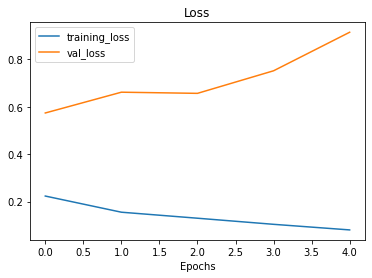

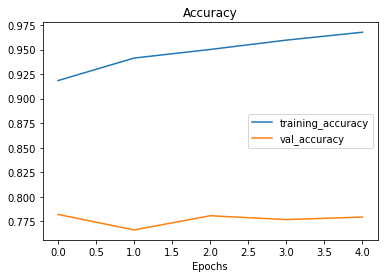

In [ ]:
plot_loss_curves(model_2_history)

Chúng ta đã có mô hình RNN được đào tạo đầu tiên sử dụng các ô LSTM. Hãy đưa ra một số dự đoán với nó.Điều tương tự sẽ xảy ra như trước đây, do hàm kích hoạt `sigmoid` trong lớp cuối cùng, khi chúng ta gọi phương thức `predict()` trên mô hình của mình, nó sẽ trả về xác suất dự đoán thay vì các lớp.

In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[3.7907854e-02],
        [6.6081131e-01],
        [9.9963570e-01],
        [6.1096571e-02],
        [3.1612421e-04],
        [9.9823904e-01],
        [5.3959686e-01],
        [9.9988639e-01],
        [9.9980181e-01],
        [3.9663017e-01]], dtype=float32))

Chúng ta có thể biến các xác suất dự đoán này thành các lớp dự đoán bằng cách làm tròn đến số nguyên gần nhất (theo mặc định, các xác suất dự đoán dưới 0,5 sẽ thành 0 và những xác suất trên 0,5 sẽ thành 1)

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

Tuyệt vời, bây giờ chúng ta hãy sử dụng hàm `caculate_results()` để đánh giá mô hình LSTM của chúng ta và hàm `Compare_baseline_to_new_results()` để so sánh nó với mô hình cơ sở.

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'f1': 0.776722451043917,
 'precision': 0.7833144267983451,
 'recall': 0.7795275590551181}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


## **Model 3: GRU**

Các đơn vị định kỳ xác định (GRU) là một cơ chế định kỳ trong mạng nơ-ron định kỳ, được giới thiệu vào năm 2014 bởi Kyunghyun Cho và cộng sự.GRU giống như một bộ nhớ ngắn hạn dài (LSTM) có cổng quên, nhưng có ít tham số hơn LSTM, vì nó thiếu cổng ra. Hiệu suất của GRU trong một số nhiệm vụ về mô hình âm nhạc đa âm, mô hình tín hiệu giọng nói và xử lý ngôn ngữ tự nhiên được nhận thấy là tương tự như của LSTM.GRU đã được chứng minh là có hiệu suất tốt hơn trên một số tập dữ liệu nhỏ hơn và ít thường xuyên hơn.

Để sử dụng ô GRU trong TensorFlow, chúng ta có thể gọi lớp `tensorflow.keras.layers.GRU()`.

Kiến trúc của mô hình do GRU cung cấp sẽ tuân theo cùng một cấu trúc mà chúng ta đã sử dụng:
```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```


In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


Chúng ta có thể thấy rõ sự khấc nhau về số lượng thông số có thể đào tạo giữa `model_2`(LSTM) và `model_3`(GRU). Sự khác biệt đến từ ô LSTM có nhiều tham số có thể đào tạo hơn ô GRU.

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210628-160739
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1657 - accuracy: 0.9323 - val_loss: 0.7495 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0843 - accuracy: 0.9696 - val_loss: 0.9116 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0693 - accuracy: 0.9708 - val_loss: 0.9212 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0582 - accuracy: 0.9753 - val_loss: 1.2910 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0498 - accuracy: 0.9777 - val_loss: 1.1823 - val_accuracy: 0.7756


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[2.3373042e-03],
        [8.0978906e-01],
        [9.9979955e-01],
        [8.3622508e-02],
        [1.0375127e-04],
        [9.9936694e-01],
        [6.1307085e-01],
        [9.9990571e-01],
        [9.9986875e-01],
        [3.9516383e-01]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'f1': 0.7725109164504043,
 'precision': 0.7797991425654591,
 'recall': 0.7755905511811023}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


## **Model 4: RNN hai chiều**

Chúng ta đã xây dựng hai RNN với các ô GRU và LSTM. Bây giờ chúng ta sẽ xem xét một loại RNN khác, RNN hai chiều.

Một RNN tiêu chuẩn sẽ xử lý một trình tự từ trái sang phải, trong đó RNN hai chiều sẽ xử lý trình tự từ trái sang phải và sau đó lại từ phải sang trái.

Mạng nơ-ron tái phát hai chiều (BRNN) kết nối hai lớp ẩn ngược chiều với cùng một đầu ra. Với hình thức học sâu chung này, lớp đầu ra có thể nhận thông tin từ trạng thái quá khứ (ngược) và tương lai (chuyển tiếp) đồng thời. Được phát minh vào năm 1997 bởi Schuster và Paliwal, BRNNs được giới thiệu để tăng lượng thông tin đầu vào có sẵn cho mạng. Ví dụ: perceptron nhiều lớp (MLP) và mạng nơ-ron trễ thời gian (TDNN) có những hạn chế về tính linh hoạt của dữ liệu đầu vào, vì chúng yêu cầu dữ liệu đầu vào của chúng phải được cố định. Mạng nơ-ron tuần hoàn tiêu chuẩn (RNN) cũng có những hạn chế vì không thể đạt được thông tin đầu vào trong tương lai từ trạng thái hiện tại. Ngược lại, BRNN không yêu cầu cố định dữ liệu đầu vào của chúng. Hơn nữa, thông tin đầu vào trong tương lai của họ có thể truy cập được từ trạng thái hiện tại.

BRNN đặc biệt hữu ích khi ngữ cảnh của đầu vào là cần thiết. Ví dụ, trong nhận dạng chữ viết tay, hiệu suất có thể được nâng cao nhờ kiến ​​thức về các chữ cái nằm trước và sau chữ cái hiện tại.

Một lần nữa, TensorFlow giúp chúng ta bằng cách cung cấp lớp `tensorflow.keras.layers.Bidirectional.` Chúng ta có thể sử dụng lớp `Bidirectional` để bọc các RNN hiện có của mình, ngay lập tức làm cho chúng có hai chiều.

In [ ]:
# Build a Bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210628-160803
Epoch 1/5
215/215 [==============================] - 8s 24ms/step - loss: 0.1056 - accuracy: 0.9661 - val_loss: 0.9359 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0516 - accuracy: 0.9780 - val_loss: 1.1973 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0451 - accuracy: 0.9787 - val_loss: 1.5062 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0470 - accuracy: 0.9785 - val_loss: 1.2575 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0401 - accuracy: 0.9816 - val_loss: 1.4946 - val_accuracy: 0.7625


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'f1': 0.7606364368852738,
 'precision': 0.7633250178480884,
 'recall': 0.7624671916010499}

In [ ]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## **CNN cho văn bản**

Trước đây,chúng ta đã sử dụng mạng nơ-ron phức hợp (CNN) cho hình ảnh nhưng chúng cũng có thể được sử dụng cho các chuỗi.

Sự khác biệt chính giữa việc sử dụng CNN cho hình ảnh và chuỗi là hình dạng của dữ liệu. Hình ảnh có 2 chiều (cao x rộng) trong khi các chuỗi thường là 1 chiều (một chuỗi văn bản).

Một kiến ​​trúc CNN điển hình cho các chuỗi sẽ giống như sau:
```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```



## **Model 5: Conv1D**

Trước khi chúng ta xây dựng mô hình CNN 1 chiều đầy đủ, hãy xem lớp tích chập 1 chiều (còn gọi là tích chập thời gian) đang hoạt động.Trước tiên, chúng ta sẽ tạo một bản nhúng của một mẫu văn bản và thử nghiệm chuyển nó qua lớp `Conv1D()` và lớp `GlobalMaxPool1D()`.

In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.04384732, -0.04675359,  0.00813144, ..., -0.04647035,
           0.00234443,  0.02890374],
         [ 0.03305096, -0.03972833,  0.01069026, ...,  0.03753715,
           0.03058189,  0.0179725 ],
         [ 0.01346377, -0.03790578,  0.00741481, ...,  0.01455047,
           0.02595956,  0.0442475 ],
         ...,
         [ 0.01773263,  0.04763007,  0.00335954, ..., -0.03156964,
           0.01510969, -0.01513702],
         [ 0.01773263,  0.04763007,  0.00335954, ..., -0.03156964,
           0.01510969, -0.01513702],
         [ 0.01773263,  0.04763007,  0.00335954, ..., -0.03156964,
           0.01510969, -0.01513702]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.04288172, 0.        , 0.        , 0.00142348,
          0.        , 0.        , 0.06188136, 0.        , 0.00414307,
          0.        , 0.05366322, 0.        , 0.        , 0.05786547,
          0.01943304, 0.

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210628-160911
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1368 - accuracy: 0.9569 - val_loss: 0.8495 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0772 - accuracy: 0.9731 - val_loss: 1.0134 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0613 - accuracy: 0.9771 - val_loss: 1.0891 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0557 - accuracy: 0.9787 - val_loss: 1.1537 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0513 - accuracy: 0.9785 - val_loss: 1.1507 - val_accuracy: 0.7612


In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'f1': 0.7597317731418467,
 'precision': 0.761395918264994,
 'recall': 0.7611548556430446}

In [ ]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 76.12, Difference: -3.15
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## **Sử dụng Nhúng đã được đào tạo(transfer learning for NLP)**

Đối với tất cả các mô hình học sâu trước đây mà chúng ta đã xây dựng và đào tạo, chúng ta đã tạo và sử dụng các bản nhúng của riêng mình từ đầu.

Tuy nhiên, một thực tế phổ biến là tận dụng các nhúng được đào tạo trước thông qua học chuyển giao. Đây là một trong những lợi ích chính của việc sử dụng mô hình sâu: có thể lấy những gì một mô hình (thường lớn hơn) đã học được (thường là trên một lượng lớn dữ liệu) và điều chỉnh nó cho trường hợp sử dụng của chúng ta.ối với mô hình tiếp theo, thay vì sử dụng lớp nhúng riêng, chúng ta sẽ thay thế nó bằng một lớp nhúng được đào tạo trước.Cụ thể hơn, chúng ta sẽ sử dụng Bộ mã hóa câu đa năng(Universal Sentence Encoder) từ TensorFlow Hub (một tài nguyên tuyệt vời chứa rất nhiều tài nguyên mô hình được đào tạo trước cho nhiều tác vụ khác nhau).

## **Model 6:  TensorFlow Hub Pretrained Sentence Encoder**



Sự khác biệt chính giữa lớp nhúng mà chúng ta đã tạo và Bộ mã hóa câu phổ quát là thay vì tạo kiểu nhúng cấp độ từ, Bộ mã hóa câu đa năng tạo ra một kiểu nhúng toàn bộ cấp độ câu.Lớp nhúng của chúng ta xuất ra một vectơ 128 chiều cho mỗi từ, trong đó, Bộ mã hóa câu đa năng xuất ra một vectơ 512 chiều cho mỗi câu.

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [ ]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Chúng ta có thể chuyển đổi mô-đun TensorFlow Hub USE(Universal Sentence Encoder) thành một lớp Keras bằng cách sử dụng lớp `hub.KerasLayer`.

> Chú ý:Do kích thước của mô-đun  TensorFlow Hub USE, có thể mất một chút thời gian để tải xuống. Sau khi tải xuống, nó sẽ được lưu vào bộ nhớ đệm và sẵn sàng để sử dụng. Và như với nhiều mô-đun TensorFlow Hub, có một phiên bản "nhỏ" của USE chiếm ít dung lượng hơn nhưng hy sinh một số hiệu suất và yêu cầu nhiều bước tiền xử lý hơn.

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

Bây giờ chúng ta đã có USE dưới dạng lớp Keras, chúng ta có thể sử dụng nó trong mô hình Keras.Sequential

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


Lưu ý số lượng các tham số trong lớp USE, đây là những trọng số được đào tạo trước mà nó học được trên các nguồn văn bản khác nhau (Wikipedia, tin tức trên web, diễn đàn câu trả lời trên web, v.v.).

Các tham số có thể đào tạo chỉ nằm trong các lớp đầu ra của chúng ta, nói cách khác, chúng ta đang giữ cố định các trọng số của USE và sử dụng nó như một công cụ trích xuất tính năng. Chúng ta có thể tinh chỉnh các trọng số này bằng cách đặt `trainable = True` khi tạo `hub.KerasLayer`.

In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210628-160951
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5046 - accuracy: 0.7805 - val_loss: 0.4459 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4149 - accuracy: 0.8156 - val_loss: 0.4363 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4005 - accuracy: 0.8216 - val_loss: 0.4343 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3925 - accuracy: 0.8263 - val_loss: 0.4291 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3849 - accuracy: 0.8305 - val_loss: 0.4248 - val_accuracy: 0.8176


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'f1': 0.816365758450113,
 'precision': 0.8190970972170162,
 'recall': 0.8175853018372703}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.76, Difference: 2.49
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.82, Difference: 0.03


# **So sánh hiệu suất của từng mô hình**

Chúng ta đã thực hiện huấn luyện một loạt các mô hình với các phương pháp khác nhau. Bây giờ là lúc để so sánh hiệu suất của các mô hình đạt được.

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,79.396325,0.803127,0.793963,0.789913
lstm,77.952756,0.783314,0.779528,0.776722
gru,77.559055,0.779799,0.775591,0.772511
bidirectional,76.246719,0.763325,0.762467,0.760636
conv1d,76.115486,0.761396,0.761155,0.759732
tf_hub_sentence_encoder,81.758530,0.819097,0.817585,0.816366


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

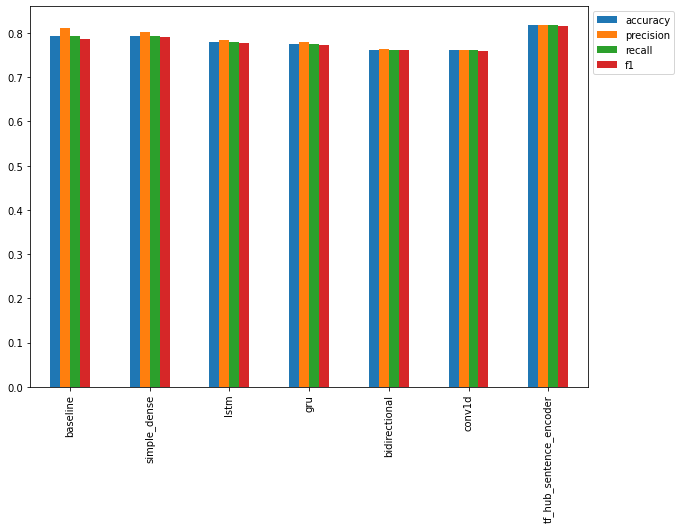

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Chúng ta có thể thấy hiện tại có vẻ như mô hình USE đang hoạt động tốt nhất.Điều này cho thấy sức mạnh của việc học chuyển giao. 

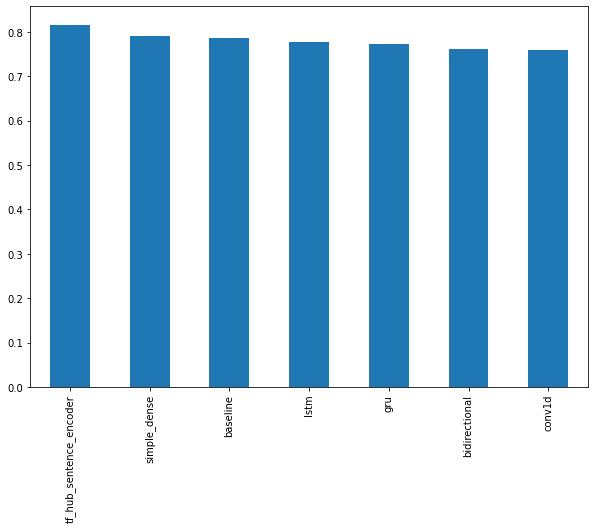

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# **Kết hợp mô hình thành 1 quần thể.**

Nhiều hệ thống sản xuất sử dụng một nhóm (nhiều mô hình khác nhau kết hợp với nhau) các mô hình để đưa ra dự đoán.

Ý tưởng đằng sau việc xếp chồng mô hình là nếu một số mô hình không tương quan đồng ý về một dự đoán, thì dự đoán đó phải mạnh mẽ hơn dự đoán được thực hiện bởi một mô hình đơn lẻ.

Mặc dù tất cả các mô hình này đều được đào tạo trên cùng một dữ liệu, nhưng chúng đều có một cách khác nhau để tìm ra các mẫu.Nếu chúng ta sử dụng ba mô hình được đào tạo tương tự, chẳng hạn như ba mô hình LSTM, thì các dự đoán mà chúng đưa ra có thể sẽ rất giống nhau.

Vì chúng ta đang giải quyết vấn đề phân loại, có một số cách chúng tôi có thể kết hợp các mô hình của mình:
1. Trung bình: Lấy xác suất dự đoán đầu ra của từng mô hình cho mỗi mẫu, kết hợp chúng và sau đó lấy trung bình.
2. Lấy đa số (Majority vote): Đưa ra dự đoán về lớp với từng mô hình của chúng ta trên tất cả các mẫu, lớp được dự đoán là lớp chiếm đa số.Ví dụ: nếu ba mô hình khác nhau dự đoán [1, 0, 1] tương ứng, thì lớp đa số là 1, do đó, đó sẽ là nhãn được dự đoán.
3. Xếp chồng mô hình: Lấy kết quả đầu ra của từng mô hình đã chọn và sử dụng chúng làm đầu vào cho mô hình khác.

Chúng ta sẽ kết hợp mô hình cơ sởi (model_0), mô hình LSTM (model_2) và mô hình USE được đào tạo trên dữ liệu đào tạo đầy đủ (model_6) bằng cách lấy trung bình các xác suất dự đoán kết hợp của từng loại.

In [ ]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.92125984251969,
 'f1': 0.7983311621095746,
 'precision': 0.7994896832822466,
 'recall': 0.7992125984251969}

In [ ]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [ ]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.793963,0.803127,0.793963,0.789913
lstm,0.779528,0.783314,0.779528,0.776722
gru,0.775591,0.779799,0.775591,0.772511
bidirectional,0.762467,0.763325,0.762467,0.760636
conv1d,0.761155,0.761396,0.761155,0.759732
tf_hub_sentence_encoder,0.817585,0.819097,0.817585,0.816366
ensemble_results,0.799213,0.799490,0.799213,0.798331


Có vẻ như nhiều kết quả của mô hình của chúng ta là tương tự. Điều này có thể có nghĩa là có một số hạn chế đối với những gì có thể học được từ dữ liệu của chúng ta. Khi nhiều thử nghiệm mô hình trả lại kết quả tương tự,nên truy cập lại dữ liệu của mình.

# **Tìm mẫu sai nhiều nhất.**

Nếu nhiều thử nghiệm mô hình của chúng ta đang trả lại kết quả tương tự, mặc dù sử dụng các loại mô hình khác nhau, thì tốt hơn hết  nên quay lại dữ liệu và kiểm tra xem tại sao lại có thể như vậy.

Một trong những cách tốt nhất để kiểm tra dữ liệu là sắp xếp các dự đoán của mô hình và tìm các mẫu mà nó sai nhiều nhất, nghĩa là, những dự đoán nào có xác suất dự đoán cao nhưng hóa ra lại sai.Để làm cho mọi thứ trở nên trực quan, chúng ta hãy lấy các lớp và xác suất dự đoán của mô hình hoạt động tốt nhất của chúng ta cùng với các mẫu xác thực (nhãn văn bản và nhãn đúng) và kết hợp chúng trong một pandas DataFrame.

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.217351
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.797780
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988894
3,@camilacabello97 Internally and externally scr...,1,0.0,0.211736
4,Radiation emergency #preparedness starts with ...,1,1.0,0.712665


Bây giờ chúng ta hãy tìm các dự đoán sai của mô hình (trong đó `target! = Pred`) và sắp xếp chúng theo xác suất dự đoán của chúng (cột `pred_prob`).

In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.925009
759,FedEx will no longer transport bioterror patho...,0,1.0,0.910468
628,@noah_anyname That's where the concentration c...,0,1.0,0.861789
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.856335
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.850560
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.848758
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.841808
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.823690
144,The Sound of Arson,0,1.0,0.812016
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.805860


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9250094294548035
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9104680418968201
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8617887496948242
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8563347458839417
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8505604267120361
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.8487579226493835
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.841807723

In [ ]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06529004126787186
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.060206759721040726
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.06001098453998566
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.05927712097764015
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05103147029876709
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04753189906477928
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

T

# **Đưa ra dự báo.**

## **Đưa ra dự đoán trên tập dữ liệu thử nghiệm**

In [ ]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 1, Prob: 0.6004689931869507
Text:
raleigh cyclone 15 gear mountain bike 26'': http://t.co/4LpPmad80G #sportinggoods http://t.co/lleFHhggrL

----

Pred: 0, Prob: 0.124332495033741
Text:
From the Archive: National Poetry Month: Anterior of a Razed Room http://t.co/7ARN4OBiyC

----

Pred: 0, Prob: 0.16306373476982117
Text:
I just heard a really loud bang outside my bedroom door and Im afraid

----

Pred: 1, Prob: 0.7208197712898254
Text:
Harper gets sassed by Albertans after calling NDP government a Û÷disaster' http://t.co/vsMOJyfzDg via @huffpostalberta #HarperBlamesAlbertans

----

Pred: 1, Prob: 0.9665955305099487
Text:
Storm is here! Violent winds and pounding rains in Evergreen. #yyc

----

Pred: 0, Prob: 0.1245657280087471
Text:
After a long battle @Spurs Matt Bonner took care of Brian Scalabrine in knockout this after... (Vine by @NBA) https://t.co/Q3mGYRDHSF

----

Pred: 0, Prob: 0.4249539375305176
Text:
Nuclear-Deal: Indo-Japan pact lies at the heart of two US reactor-base

## Dự đoán trên Tweet thực tế


In [ ]:
tweet = "Life like an ensemble: take the best choices from others and make your own"

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=tweet)

Pred: 0.0 (not real disaster) Prob: 0.05542650818824768
Text:
Life like an ensemble: take the best choices from others and make your own


In [ ]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [ ]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9705262780189514
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [ ]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9781783223152161
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon
